# Finetuning BERT for IR / Semantic search

We will briefly talk about sparse and dense represenations of texts and take a quick glance at techniques that came before the Transformers.

## Sparse representation of text: One-hot vectors

Traditionally we use a one-hot vectors to represent text as vectors. For example, for a sentence "a quick brown fox", we could end up with following one hot vectors.

    [1, 0, 0, 0] - a
    [0, 1, 0, 0] - quick
    [0, 0, 1, 1] - brown
    [0, 0, 0, 1] - fox
    
It's easy to see that for larger vocabularies such as web pages, faq articles, etc. i.e. the kind we typically see in IR settings, these vectors will be very long and very sparse with the dimensionality equal to the vocab size.

These vectors also have no information about the words they represent. For example, here "quick" is as similar to "fox" as it is to the word "brown".

** Vocab size refers to the number of unique tokens/terms used in a collection of documents.

## Distributional Semantics

Formally, dense representation of text is easy to define

$$ f(text) => \!R^n $$

In the above example, if we take n = 5, our dense vectors might look like

    [0.98, -1.12, 0.21, 0.01] - a
    [1.22, 2.12, -3.12, 3.11] - quick
    [-1.23, 4.30, 1.16, 0.90] - brown
    [0.11, 0.12, -1.23, 4.65] - fox

To capture the meaning of words in such dense vectors, we need to consider the notion of context for words in a piece of text. For example, consider these texts:

    1. A bottle of ________ is on the table.
    2. Everyone likes ________.
    3. ________ makes you drunk.
    4. We make ________ out of corn.

Now consider the word that could appear in the blank position. Given the context, we can guess it's an alcoholic beverage (the correct answer is `tezguino` btw).
Other alcoholic drinks made of corn also qualify here. The idea is that we can guess the word based on the it's surrounding words or the context in which it appears.

Techniques like word2vec, LSTMs, transformers build on top of this idea.

## Before Transformers

### Count based methods

The general process of creating dense represenations using count based methods is to:
 1. Create a word-context matrix.
 2. Reduce it's dimensionality.

We reduce dimensionality because of the large vocab size as well as the sparsity of such matrices(most of the terms are 0 in the matrix).
One such technique is LSA(Latent Semantic Analysis) which does SVD on the term document matrix(could be TF_IDF).

| ![](assets/lsa.jpg) | 
|:--:| 
| Fig. 1. Dense representation of texts using SVD on term-document matrix. (Image source: https://www.frontiersin.org/articles/10.3389/fphys.2013.00008/full)  |
<br>

### Word2Vec

Word2Vec works on the similar premise of encoding contextual information into the dense representation for a word.
Word2Vec wors in an iterative manner:
 - Start with a huge text corpus.
 - Go over the text using a sliding window. At each step, take a center word i and the context words(within the window).
 - For the center word, compute probabilites for all the words in the vocab using softmax.
 - Computer cross entropy loss for the context words and backprop over the embeddings to refine them.

| ![](assets/w2v_window.png) | 
|:--:| 
| Fig. 2. Illustration of Word2Vec - center and context words. (Image source: https://www.frontiersin.org/articles/10.3389/fphys.2013.00008/full)  |

There are two methods used to create the word embeddings:
 - CBOW(Continuous bag of words): Uses the context words to predict the center word.
 - Skip gram: Uses the center word to predict the context words.

| ![](assets/w2v.png) | 
|:--:| 
| Fig. 3. Illustration of Word2Vec - CBOW and SkipGram. (Image source: https://www.researchgate.net/figure/CBOW-and-Skip-Gram-neural-architectures_fig14_325651523)  |


The ojective function is formulated as

$$ J(\theta) = - \frac{1}{T} \sum_{t=1}^T \sum_{-m<=j<=m, j\neq0} P(w_{t+j}|w_t,\theta) $$

<center>𝑃(𝑤𝑡+𝑗|𝑤𝑡,𝜃) - Probability of the context word given center word(skip gram)</center>

Essentially we are going over the whole text using a sliding window and computing the loss using the probability from softmax.

Some of the drawbacks of Wor2Vec:
 - Essentially a bag of words technique as we don't consider the order in which the words appear in a window.
 - Limited window size makes the learned representaions very limited in the sense that they only capture very local contexts.
 - We can't capture multiple embeddings for the same word in different context, for example, "a river bank", "bank deposit". The word "bank" ends with a single embedding even though it means two different things here.
 - Out of vocab words are not handeled.

There are methods to deal with some of these issues, like subword embeddings using fastText can handle out of vocab words. In general these bag of wordd techniques have fallen out of favor for methods we are going to discuss next.
<br>

### Recurrent Neural Nets

Before Transformers, RNNs especially LSTMs were all the rage but they have also fallen out of favour because of the following drawbacks:
 - The temporal dependence in updating the hidden state(over the tokens) make then slow to train and not let us effeciently use the modern hardware for training(gpus).
 - Even though theoratically LSTMs can handle arbitrarily long sequences, in practice they suffer from vanishing gradient.
 - The biggest problem is the bottleneck at the end of the sequence where we are trying to store all the historical information from the sequence into one final hidden vector.

| ![](assets/lstm_bottleneck.png) | 
|:--:| 
| Fig. 4. Illustration of the bottleneck in LSTMs. (Image source: https://www.researchgate.net/figure/Encoder-decoder-model-using-stacked-LSTMs-for-encoding-and-one-LSTM-layer-for-decoding_fig1_340443252)  |

The attention mechanism on top of the LSTMs help us solve this bottleneck issue but we still struggle with slow training times as discussed in the first point.

As Transformers have proven, we don't really need this recurrent mechanism, by adding positional information into each token embedding and doing self attention on top of it, we can learn powerful representations of text and use them for all the downstream NLP tasks.

## Transformers for semantic search

** Note that we won't go into the architectural details of transfomer based models but jump straight into using these models(finetuning) for IR. There is enough content out there on this topic to justify a quick summary here.

We will cover the following techniques/architectures over multiple notebooks:
- Bi-Encoders
- Cross-Encoders
- Multilingual models
- ColBERT
- Doc2Query
- Domain adaptation
    - TSDAE(Transformer-based Sequential Denoising Auto Encoder)
    - SimCSE(Simple Contrastive learning of Sentence Embeddings)
    - GPL(Generative Pseudo Labeling)
- QnA
- ANNs for indexing and lookup

Later we will also look into ANN(Approximate nearest neighbour) techniques used for indexing and retrieval of dense embeddings.

In rest of this notebook, we will dive into the original [Sentence-BERT paper](https://arxiv.org/abs/1908.10084) by [Nils Reimers](https://arxiv.org/search/cs?searchtype=author&query=Reimers%2C+N) and [Iryna Gurevych](https://arxiv.org/search/cs?searchtype=author&query=Gurevych%2C+I). Here is a quick summary by the authors.

> BERT (Devlin et al., 2018) and RoBERTa (Liu et al., 2019) has set a new state-of-the-art performance on sentence-pair regression tasks like semantic textual similarity (STS). However, it requires that both sentences are fed into the network, which causes a massive computational overhead: Finding the most similar pair in a collection of 10,000 sentences requires about 50 million inference computations (~65 hours) with BERT. The construction of BERT makes it unsuitable for semantic similarity search as well as for unsupervised tasks like clustering.
>
> In this publication, we present Sentence-BERT (SBERT), a modification of the pretrained BERT network that use siamese and triplet network structures to derive semantically meaningful sentence embeddings that can be compared using cosine-similarity. This reduces the effort for finding the most similar pair from 65 hours with BERT / RoBERTa to about 5 seconds with SBERT, while maintaining the accuracy from BERT.
>
> We evaluate SBERT and SRoBERTa on common STS tasks and transfer learning tasks, where it outperforms other state-of-the-art sentence embeddings methods.

We will fintune the base-bert model using a siamese architecture(Bi-Encoder) on the SNLI data(the paper mentions using both the SNLI and Multi-NLI datasets).

> Natural language inference(NLI) is the task of determining whether a “hypothesis” is true (entailment), false (contradiction), or undetermined (neutral) given a “premise”.
>
> Example:
>
> | Premise | Label | Hypothesis |
| ------- | ----- | ---------- |
| A man inspects the uniform of a figure in some East Asian country. | contradiction | The man is sleeping. |
| An older and younger man smiling. | neutral | Two men are smiling and laughing at the cats playing on the floor. |
| A soccer game with multiple males playing. | entailment | Some men are playing a sport. |
>
> Source: http://nlpprogress.com/english/natural_language_inference.html
>
> ** NLI is also referred as a textual entailment task.

![](assets/sbert_architecture.png)

In the figure, though it looks like two different BERT models, we are finetuning only one BERT model by passing both the sentences, pooling and then feeding the emebddings into a fully connected network for classification using the cross-entropy(softmax) as the loss function.

We will train the SBERT architecture from the above figure. In the paper the authors mention three obective functuins:
- **Classification objective** - As depicted in the picture.
- **Regression objective** - The cosine-similarity between the two sentence embeddings *u* and *v* is comupted(Figure 2) and the model is finetuned using the mean-squared loss function.
- **Triplet objective** - Or MNR (Multiple Negative Ranking) loss. We will discuss this in detail in the next section. MNR in general performs better for semnatic search and other use cases like clustering, paraphrase mining etc using dense embeddings.

![](assets/sbert_pooling_concat.png)

A quick note on the pooling operation, the authors mention that they tried pooling using the CLS-token, by computing the mean over all the token level embeddings (MEAN-strategy) and computing the max over the all the token level embeddings (MAX-strategy). Out of the three, MEAN pooling gave the best results hence we will try that.

![](assets/sbert_compare_glove.png)

One might wonder, why the need to finetune at all, why not use the CLS-token or the MEAN pooling strategy directly with a bert model trained on MLM task. Here also, the authors share some results, unless we finetune specifically for STS(Semantic Textual Similarity) tasks, the BERT models perform worse than the Avg. GloVE embeddings on STS tasks.

They also tried various concatenation strategies before feeding the embeddings into the fully connected layer. (*u*, *v*, |*u* - *v*|) gave the best results.

Let's start ...

In [1]:
import random
from typing import Callable, Iterable

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import BertTokenizerFast, BertModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [14]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Data preparation

We will import the snli data and tokenize it beforehand to save compute during the training phase.

In [3]:
dataset = datasets.load_dataset("snli", split="train")

# there are some pairs of "premise" and "hypothesis" which haven't been
# labeled in this dataset, we will filter those out first
dataset = dataset.filter(lambda x: False if x["label"] == -1 else True)

len(dataset), dataset[0]

Reusing dataset snli (/home/utsav/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Loading cached processed dataset at /home/utsav/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-0436d94218380653.arrow


(549367,
 {'premise': 'A person on a horse jumps over a broken down airplane.',
  'hypothesis': 'A person is training his horse for a competition.',
  'label': 1})

In [5]:
preimse_lengths, hypothesis_lengths = [], []
for data in tqdm(dataset):
    if random.random() > 0.9:
        preimse_lengths.append(len(data["premise"]))
        hypothesis_lengths.append(len(data["hypothesis"]))

100%|██████████████████████████████████████████████████████████████| 549367/549367 [00:28<00:00, 19413.23it/s]


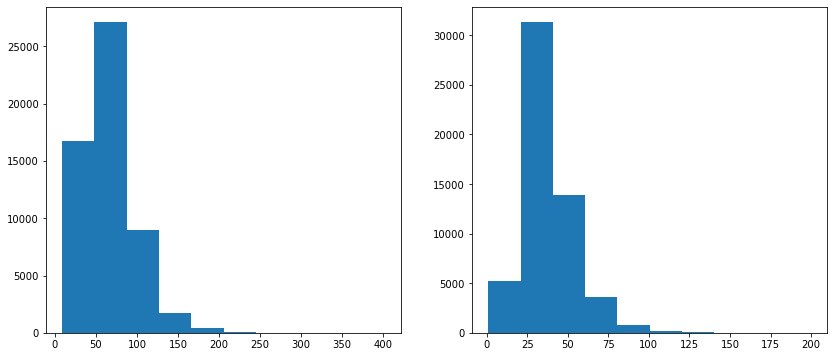

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].hist(preimse_lengths)
ax[1].hist(hypothesis_lengths);

In [15]:
%%time

tokenized_premises = tokenizer([data["premise"] for data in dataset],
                               max_length=128, padding="max_length",
                               truncation=True, verbose=True)

tokenized_hypothesis = tokenizer([data["hypothesis"] for data in dataset],
                                 max_length=128, padding="max_length",
                                 truncation=True, verbose=True)

CPU times: user 2min 8s, sys: 1min 37s, total: 3min 46s
Wall time: 1min 30s


In [16]:
class SnliDataset(Dataset):
    def __init__(self, premise_tokens: dict, hypothesis_tokens: dict, labels: Iterable[str]):
        self.premise_tokens = premise_tokens
        self.hypothesis_tokens = hypothesis_tokens
        self.labels = labels
        self._init_data()

    def _init_data(self) -> None:
        self.data = []
        for pt_ids, pt_am, ht_ids, ht_am, label in zip(
            self.premise_tokens["input_ids"], self.premise_tokens["attention_mask"],
            self.hypothesis_tokens["input_ids"], self.hypothesis_tokens["attention_mask"],
            self.labels
        ):
            data = {}
            data["premise_input_ids"] = torch.tensor(pt_ids, dtype=torch.long)
            data["premise_attention_mask"] = torch.tensor(pt_am, dtype=torch.long)
            data["hypothesis_input_ids"] = torch.tensor(ht_ids, dtype=torch.long)
            data["hypothesis_attention_mask"] = torch.tensor(ht_am, dtype=torch.long)
            data["label"] = torch.tensor(label, dtype=torch.long)
            self.data.append(data)

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return self.data[ix]

    def __len__(self) -> int:
        return len(self.data)

In [17]:
%%time

snli_dataset = SnliDataset(tokenized_premises, tokenized_hypothesis,
                           (data["label"] for data in dataset))

CPU times: user 48.2 s, sys: 1.06 s, total: 49.3 s
Wall time: 49.2 s


In [18]:
train_ratio = 0.8
n_total = len(snli_dataset)
n_train = int(n_total * train_ratio)
n_val = n_total - n_train

train_dataset, val_dataset = random_split(snli_dataset, [n_train, n_val])

batch_size = 16  # mentioned in the paper
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [14]:
next(iter(train_dataloader))

{'premise_input_ids': tensor([[  101,  1037,  2312,  ...,     0,     0,     0],
         [  101,  1037,  2158,  ...,     0,     0,     0],
         [  101,  1037,  2158,  ...,     0,     0,     0],
         ...,
         [  101,  1037, 21294,  ...,     0,     0,     0],
         [  101,  6001,  1998,  ...,     0,     0,     0],
         [  101,  1037,  2316,  ...,     0,     0,     0]]),
 'premise_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'hypothesis_input_ids': tensor([[  101,  1996,  2111,  ...,     0,     0,     0],
         [  101,  1037,  2158,  ...,     0,     0,     0],
         [  101,  1037,  2711,  ...,     0,     0,     0],
         ...,
         [  101,  1037, 21294,  ...,     0,     0,     0],
         [  101,  6001,  1998,  ...,     0,     0,     0],
         [  101,  2093, 

### Model config

Here we will setup out custom SBERT model as detailed in the diagram from the paper.

In [27]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


def encode(input_texts: list[str], tokenizer: BertTokenizerFast, model: BertModel, device: str = "cpu"
) -> torch.tensor:

    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=128,
                                padding='max_length', truncation=True, return_tensors="pt")
    token_embeds = model(tokenized_texts["input_ids"].to(device),
                         tokenized_texts["attention_mask"].to(device)).last_hidden_state
    pooled_embeds = mean_pool(token_embeds, tokenized_texts["attention_mask"].to(device))
    return pooled_embeds

In [17]:
class Sbert(torch.nn.Module):
    def __init__(self, max_length: int = 128):
        super().__init__()
        self.max_length = max_length
        self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size * 3, 3)


    def forward(self, data: datasets.arrow_dataset.Dataset) -> torch.tensor:
        premise_input_ids = data["premise_input_ids"].to(device)
        premise_attention_mask = data["premise_attention_mask"].to(device)
        hypothesis_input_ids = data["hypothesis_input_ids"].to(device)
        hypothesis_attention_mask = data["hypothesis_attention_mask"].to(device)

        out_premise = self.bert_model(premise_input_ids, premise_attention_mask)
        out_hypothesis = self.bert_model(hypothesis_input_ids, hypothesis_attention_mask)
        premise_embeds = out_premise.last_hidden_state
        hypothesis_embeds = out_hypothesis.last_hidden_state

        pooled_premise_embeds = mean_pool(premise_embeds, premise_attention_mask)
        pooled_hypotheses_embeds = mean_pool(hypothesis_embeds, hypothesis_attention_mask)

        embeds =  torch.cat([pooled_premise_embeds, pooled_hypotheses_embeds,
                             torch.abs(pooled_premise_embeds - pooled_hypotheses_embeds)],
                            dim=-1)
        return self.linear(embeds)

In [18]:
model = Sbert()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
#  optimizer, lr, num_warmup steps have been picked from the paper
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
total_steps = len(train_dataset) // batch_size
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps,
                                            num_training_steps=total_steps - warmup_steps)

loss_fn = torch.nn.CrossEntropyLoss()

In [20]:
model = model.to(device)

### Training loop

In [21]:
def get_train_step_fn(model: torch.nn.Module, optimizer: torch.optim.Optimizer,
                      scheduler: torch.optim.lr_scheduler.LambdaLR,
                      loss_fn: torch.nn.CrossEntropyLoss):

    def train_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.train()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        return loss.item()

    return train_step_fn


def get_val_step_fn(model: torch.nn.Module, loss_fn: torch.nn.CrossEntropyLoss):

    def val_step_fn(x: torch.tensor, y: torch.tensor) -> float:
        model.eval()
        yhat = model(x)
        loss = loss_fn(yhat, y)
        return loss.item()

    return val_step_fn


def mini_batch(
    dataloader: DataLoader, step_fn: Callable[torch.tensor, torch.tensor], is_training: bool = True
) -> tuple[np.array, list[float]]:

    mini_batch_losses = []

    if is_training:
        print("\nTraining ...")
    else:
        print("\nValidating ...")
    n_steps = len(dataloader)
    for i, data in enumerate(dataloader):
        loss = step_fn(data, data["label"].to(device))
        mini_batch_losses.append(loss)
        if i % (batch_size * 100) == 0:
            print(f"step {i:>5}/{n_steps}, loss = {loss: .3f}")

    return np.mean(mini_batch_losses), mini_batch_losses

In [22]:
%%time

n_epochs = 1  # mentioned in the paper

train_step_fn = get_train_step_fn(model, optimizer, scheduler, loss_fn)
val_step_fn = get_val_step_fn(model, loss_fn)

train_losses, train_mini_batch_losses = [], []
val_losses, val_mini_batch_losses = [], []

for epoch in range(1, n_epochs + 1):
    train_loss, _train_mini_batch_losses = mini_batch(train_dataloader, train_step_fn)
    train_mini_batch_losses += _train_mini_batch_losses
    train_losses.append(train_loss)

    with torch.no_grad():
        val_loss, _val_mini_batch_losses = mini_batch(val_dataloader, val_step_fn, is_training=False)
        val_mini_batch_losses += _val_mini_batch_losses
        val_losses.append(val_loss)


Training ...
step     0/27469, loss =  1.108
step  1600/27469, loss =  0.621
step  3200/27469, loss =  0.453
step  4800/27469, loss =  0.540
step  6400/27469, loss =  0.633
step  8000/27469, loss =  0.598
step  9600/27469, loss =  0.308
step 11200/27469, loss =  0.669
step 12800/27469, loss =  0.595
step 14400/27469, loss =  0.710
step 16000/27469, loss =  0.502
step 17600/27469, loss =  0.339
step 19200/27469, loss =  0.350
step 20800/27469, loss =  0.324
step 22400/27469, loss =  0.572
step 24000/27469, loss =  0.699
step 25600/27469, loss =  0.494
step 27200/27469, loss =  0.555

Validating ...
step     0/6868, loss =  0.652
step  1600/6868, loss =  0.215
step  3200/6868, loss =  0.391
step  4800/6868, loss =  0.281
step  6400/6868, loss =  0.355
CPU times: user 52min 10s, sys: 26min 29s, total: 1h 18min 39s
Wall time: 1h 18min 35s


In [23]:
train_loss, val_loss

(0.5563077898345832, 0.4604906574972126)

In [24]:
# running mean of the mini batch losses

window_size = 32

train_mb_running_loss = []
for i in range(len(train_mini_batch_losses)-window_size):
    train_mb_running_loss.append(np.mean(train_mini_batch_losses[i:i+window_size]))

val_mb_running_loss = []
for i in range(len(val_mini_batch_losses)-window_size):
    val_mb_running_loss.append(np.mean(val_mini_batch_losses[i:i+window_size]))

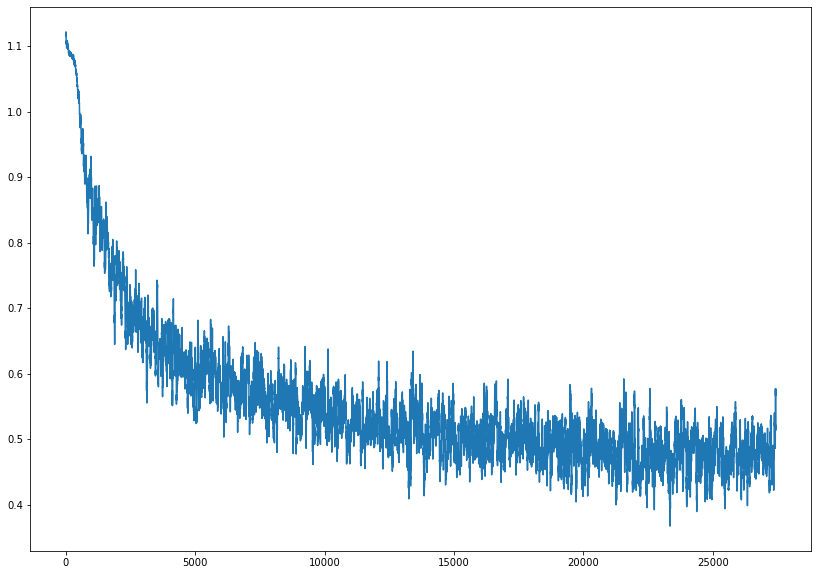

In [25]:
fix, ax = plt.subplots(figsize=(14, 10))
ax.plot(range(len(train_mb_running_loss)), train_mb_running_loss);

In [34]:
model.bert_model.save_pretrained("models/sbert_softmax.pt")

### Evaluation 

In [27]:
def plot_heatmap(similarity_matrix: np.array, sentences: list[str]) -> None:
    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(similarity_matrix, cmap='YlGn', interpolation='nearest')

    ax.set_yticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])
    ax.set_xticks(np.arange(len(sentences)), labels=[txt[:50] + "..." for txt in sentences])

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    for i in range(len(sentences)):
        for j in range(len(sentences)):
            text = ax.text(j, i, round(similarity_matrix[i, j], 2),
                           ha="center", va="center", color="w")

    fig.tight_layout()
    plt.show()

In [28]:
sentences = [
    "What should I do to improve my English ?",
    "What should I do to improve my spoken English?",
    "Can I improve my English?",
    "How can I earn money online?",
    "How do I earn money online?",
    "Can I earn money online?",
    "What are some mind-blowing Mobile gadgets that exist that most people don't know about?",
    "What are some mind-blowing gadgets and technologies that exist that most people don't know about?",
    "What are some mind-blowing mobile technology tools that exist that most people don't know about?"
]

In [29]:
pooled_embeds = encode(sentences, model.bert_tokenizer, model.bert_model, device)
pooled_embeds = pooled_embeds.cpu().detach().numpy()

Our finetuned model 

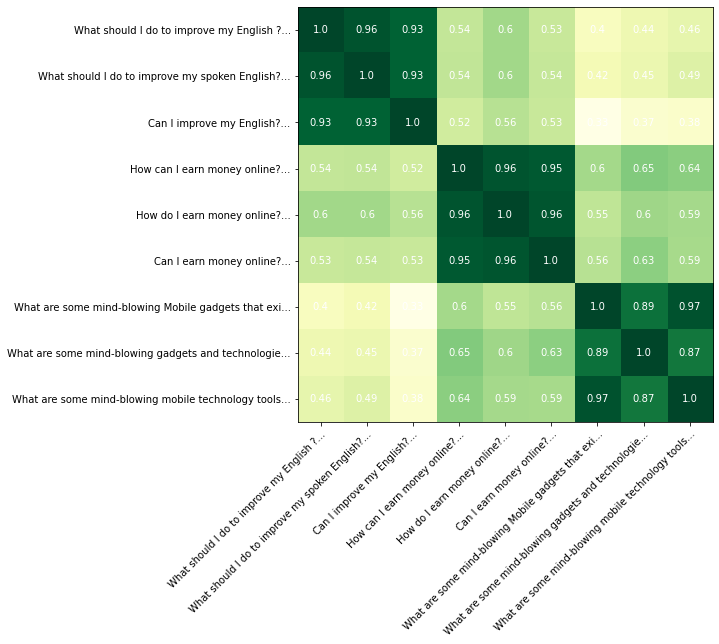

In [30]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

In [31]:
bert_model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
pooled_embeds = encode(sentences, tokenizer, bert_model, "cpu")
pooled_embeds = pooled_embeds.detach().numpy()

Original base bert model

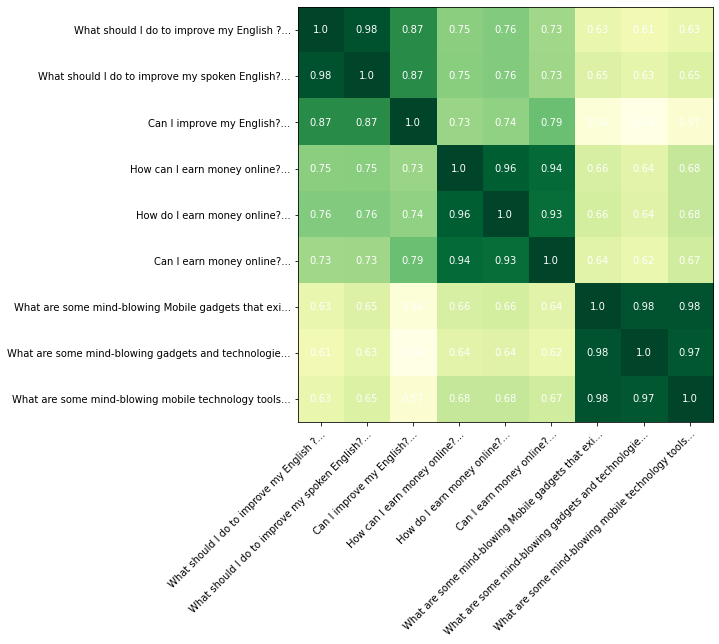

In [33]:
similarity_matrix = cosine_similarity(pooled_embeds)
plot_heatmap(similarity_matrix, sentences)

On a visual inspection we can see that both the models are doing a good job in finding the text clusters. The model we finetuned is doing a better job at pushing down the scores in the dissimilar clusters. The original bert-base model is scoring pretty much every pair of text above 0.6.

Let's evaluate the models on a STS dataset.

In [28]:
sbert_model = model.bert_model
bert_model = bert_model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
sts = datasets.load_dataset("glue", "stsb", split="validation")
len(sts), sts[0]

Reusing dataset glue (/home/utsav/.cache/huggingface/datasets/glue/stsb/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


(1500,
 {'sentence1': 'A man with a hard hat is dancing.',
  'sentence2': 'A man wearing a hard hat is dancing.',
  'label': 5.0,
  'idx': 0})

In [30]:
sentence1s = [data["sentence1"] for data in sts]
sentence2s = [data["sentence2"] for data in sts]
normalized_labels = [data["label"] / 5 for data in sts]

In [69]:
def cos_sim_in_batches(
    batch_size: int, s1_texts: list[str], s2_texts: list[str],
    tokenizer: BertTokenizerFast, model: BertModel, cos_sim_f: Callable
) -> torch.tensor:

    cos_sims = None
    n_batches = len(s1_texts) // batch_size + int(len(s1_texts) % batch_size != 0)
    for i in range(n_batches):
        s1_batch = s1_texts[i*batch_size: (i+1)*batch_size]
        s2_batch = s2_texts[i*batch_size: (i+1)*batch_size]
        if i == 0:
            cos_sims = cos_sim_f(encode(s1_batch, tokenizer, model, "cuda").detach(),
                                 encode(s2_batch, tokenizer, model, "cuda").detach())
        else:
            _cos_sims = cos_sim_f(encode(s1_batch, tokenizer, model, "cuda").detach(),
                                  encode(s2_batch, tokenizer, model, "cuda").detach())
            cos_sims = torch.cat([cos_sims, _cos_sims])
    
    return cos_sims

In [70]:
cos_sim_f = torch.nn.CosineSimilarity()
sbert_cos_sims = cos_sim_in_batches(16, sentence1s, sentence2s, tokenizer, sbert_model, cos_sim_f)
bert_cos_sims = cos_sim_in_batches(16, sentence1s, sentence2s, tokenizer, bert_model, cos_sim_f)

In [71]:
stats.spearmanr(sbert_cos_sims.cpu().detach().numpy(), np.array(normalized_labels))

SpearmanrResult(correlation=0.7674179904574383, pvalue=1.7844520619824385e-291)

In [72]:
stats.spearmanr(bert_cos_sims.cpu().detach().numpy(), np.array(normalized_labels))

SpearmanrResult(correlation=0.5931769556210932, pvalue=3.0261969816970313e-143)

Our finetuned model is doing much better than the bert-base model on STS task with a spearman rank coorelation of `.76` vs `.59`.

---

## Reference

[1] https://lena-voita.github.io/nlp_course/word_embeddings.html

[2] [Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks](https://arxiv.org/pdf/1908.10084.pdf)

[3] https://www.pinecone.io/learn/train-sentence-transformers-softmax/